In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


In [3]:
train_path="rps-final-dataset/train"
test_path="rps-final-dataset/test"
val_path="rps-final-dataset/val"

In [4]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [5]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)
    

In [6]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)
    

In [7]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [8]:
train_x.shape,test_x.shape,val_x.shape

((1401, 224, 224, 3), (437, 224, 224, 3), (350, 224, 224, 3))

In [9]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 1401 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Found 350 images belonging to 3 classes.


In [12]:
training_set.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [13]:
train_y=training_set.classes

In [14]:
test_y=test_set.classes

In [15]:
val_y=val_set.classes

In [16]:
train_y.shape,test_y.shape,val_y.shape

((1401,), (437,), (350,))

In [17]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [18]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [19]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

In [20]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [23]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
44/44 [==============================] - 466s 11s/step - accuracy: 0.8251 - loss: 0.5032 - val_loss: 0.0680 - val_accuracy: 0.9857
Epoch 2/10
44/44 [==============================] - 401s 9s/step - accuracy: 0.9900 - loss: 0.0462 - val_loss: 0.0525 - val_accuracy: 0.9800
Epoch 3/10
44/44 [==============================] - 401s 9s/step - accuracy: 0.9971 - loss: 0.0259 - val_loss: 0.0293 - val_accuracy: 1.0000
Epoch 4/10
44/44 [==============================] - 420s 10s/step - accuracy: 0.9993 - loss: 0.0174 - val_loss: 0.0316 - val_accuracy: 0.9886
Epoch 5/10
44/44 [==============================] - 411s 9s/step - accuracy: 1.0000 - loss: 0.0121 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 6/10
44/44 [==============================] - 403s 9s/step - accuracy: 1.0000 - loss: 0.0091 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 7/10
44/44 [==============================] - 401s 9s/step - accuracy: 1.0000 - loss: 0.0074 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 8/10


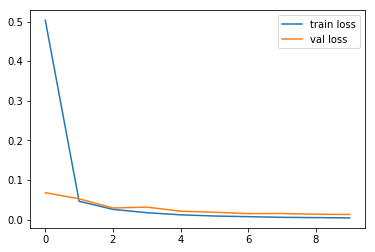

In [24]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

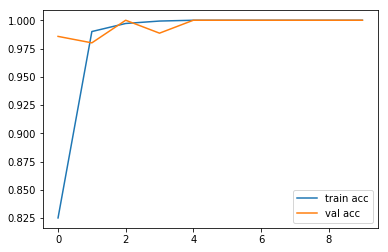

In [25]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [26]:
model.evaluate(test_x,test_y,batch_size=32)

14/14 [==============================] - 91s 6s/step - accuracy: 0.9977 - loss: 0.0186


[0.018645575270056725, 0.9977116584777832]

In [27]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [28]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [29]:
accuracy_score(y_pred,test_y)

0.9977116704805492

In [30]:
print(classification_report(y_pred,test_y))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       141
          1       1.00      0.99      1.00       146
          2       1.00      1.00      1.00       150

avg / total       1.00      1.00      1.00       437



In [31]:
confusion_matrix(y_pred,test_y)

array([[141,   0,   0],
       [  1, 145,   0],
       [  0,   0, 150]], dtype=int64)

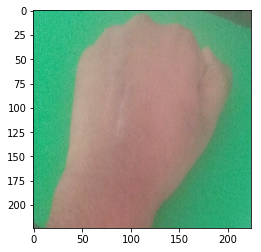

Rock


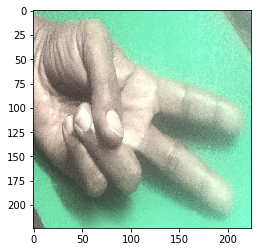

Scissors


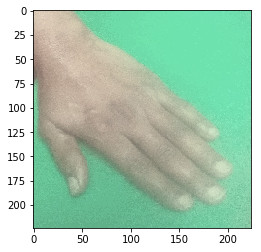

Paper


In [36]:
path="rps-results"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]>0.5:
        print("Paper")
    elif pred[0][1]>0.5:
        print("Rock")
    elif pred[0][2]>0.5:
        print("Scissors")
    else:
        print("Unknown")

In [33]:
model.save("vgg-rps-final.h5")